In [1]:
import torch
import torchvision
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
import time
import skimage
import pandas as pd
import numpy as np
import random

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import requests
import os

# Check if the file already exists
if os.path.isfile("data/titanic.csv"):
    print("The file 'data/titanic.csv' already exists.")
else:
  # URL of the file to be downloaded
  url = "https://raw.githubusercontent.com/pabair/ki-lab-ss23/main/data/titanic.csv"

  # Make a request to get the content of the CSV file
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Create the directory if it does not exist
      os.makedirs("data", exist_ok=True)

      # Write the content to a local file
      with open("data/titanic.csv", "wb") as file:
          file.write(response.content)
      print("Download successful.")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

The file 'data/titanic.csv' already exists.


In [3]:
#look at the csv file
titanic = pd.read_csv('data/titanic.csv')
print(titanic.head())


#look at the relevant data of the columns
selected_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']
titanic = titanic[selected_columns]

#check for missing values
print(titanic.columns[titanic.isnull().any()].tolist())

#Embarked doesnt mantter since it is one hot encoded
#for Age we should fill the missing values with the mean
titanic.head()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
['

In [4]:
class TitanicDataSet(torch.utils.data.Dataset):
    def __init__(self, csv_file,train=True,drop_age_nan=True):
        """
        Args:
            csv_file (string): Path to the csv file.
            train (bool): If True, the training set is loaded, otherwise the test set is loaded.
        """
        titanic = pd.read_csv(csv_file, dtype={'SibSp': float, 'Parch': float, 'Fare': float, 'Age': float})

        #The dataset is sorted by passenger id just to be sure:  shuffle the data for better splitting later
        titanic = titanic.sample(frac=1, random_state=42).reset_index(drop=True)


        selected_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']
        self.survived = titanic['Survived']
        self.features = titanic[selected_columns]

        #we assume we can do the scaling before the split


        #drop missing values in age or fill with mean
        if drop_age_nan:
            self.survived = self.survived.drop(self.features[self.features['Age'].isnull()].index).reset_index(drop=True)
            self.features = self.features.dropna(subset=['Age']).reset_index(drop=True)
        else:
            self.features.loc[:,'Age'] = self.features['Age'].fillna(self.features['Age'].mean())

        #scaling the features to be between 0 and 1
        #scaled features:  Age, # of Siblings/Spouses Aboard, # of Parents/Children Aboard, Fare
        to_scale = ['Age','Fare','SibSp','Parch']
        self.features.loc[:,to_scale] = self.features[to_scale]/self.features[to_scale].max()

        #one hot encoding the categorical variables
        #scaled features:  Ticket class, Sex, Port of Embarkation
        self.features = pd.get_dummies(self.features, columns=['Pclass','Sex','Embarked'])

        #splitting the data into training and test set
        if train:
            # self.features = self.features[:int(0.8*len(self.features))]
            # self.survived = self.survived[:int(0.8*len(self.survived))]
            self.features = self.features[int(0.2*len(self.features)):]
            self.survived = self.survived[int(0.2*len(self.survived)):]
        else:
            # self.features = self.features[int(0.8*len(self.features)):]
            # self.survived = self.survived[int(0.8*len(self.survived)):]
            self.features = self.features[:int(0.2*len(self.features))]
            self.survived = self.survived[:int(0.2*len(self.survived))]

        self.features = torch.tensor(self.features.astype(np.float32).values,dtype=torch.float32)
        self.survived = torch.tensor(self.survived.astype(np.float32).values,dtype=torch.float32)


    def __len__(self):
        return len(self.survived)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.features[idx], self.survived[idx])

In [5]:
drop_age_nan=True
titanic_train = TitanicDataSet('data/titanic.csv',train=True,drop_age_nan=drop_age_nan)
titanic_val = TitanicDataSet('data/titanic.csv',train=False,drop_age_nan=drop_age_nan)

print("Length of training data: ",len(titanic_train))
print("Length of validation data: ",len(titanic_val))

print("Size of features: ",len(titanic_train[0][0]))

for i, sample in enumerate(titanic_train):
    print(i, sample)
    if i == 2:
        break


Length of training data:  572
Length of validation data:  142
Size of features:  12
0 (tensor([0.5688, 0.0000, 0.0000, 0.0556, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 1.0000]), tensor(0.))
1 (tensor([0.2875, 0.0000, 0.0000, 0.0254, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 1.0000]), tensor(0.))
2 (tensor([0.4000, 0.0000, 0.0000, 0.0155, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 1.0000]), tensor(0.))


In [6]:
#sanity checks to see if any overlap in training and test data
same = 0

for i in range(len(titanic_train)):
    for j in range(len(titanic_val)):
        if torch.equal(titanic_train[i][0],titanic_val[j][0]):
            #print("Same sample found at index ",i," in training and index ",j," in validation set.")
            #print(titanic_train[i][0])
            same += 1

print("Number of same samples in training and validation set: ",same)

same2 = 0
for i in range(len(titanic_train)):
    for j in range(i+1,len(titanic_train)):
        if torch.equal(titanic_train[i][0],titanic_train[j][0]):
            #print("Same sample found at index ",i," and index ",j," in training set.")
            #print(titanic_train[i][0])
            same2 += 1

print("Number of same samples in training set: ",same2)

Number of same samples in training and validation set:  11
Number of same samples in training set:  44


In [7]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)

    torch.nn.init.kaiming_uniform_(self.linear1.weight, nonlinearity='relu')

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu = F.relu(self.linear1(x))
    y_pred = torch.sigmoid(self.linear2(h_relu))[:,0]
    return y_pred

In [8]:
class NLayerNet(torch.nn.Module):
  def __init__(self, D_in, H_arr, D_out, act_func=F.relu):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(NLayerNet, self).__init__()
    self.linearIn = torch.nn.Linear(D_in, H_arr[0])
    if act_func == F.relu:
        torch.nn.init.kaiming_uniform_(self.linearIn.weight, nonlinearity='relu')

    self.linear_Arr = []
    for h in range(1,len(H_arr)):
        self.linear_Arr.append(torch.nn.Linear(H_arr[h-1], H_arr[h]))
        if act_func == F.relu:
            torch.nn.init.kaiming_uniform_(self.linear_Arr[-1].weight, nonlinearity='relu')
    self.linearOut = torch.nn.Linear(H_arr[-1], D_out)

    self.act_func = act_func

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu = self.act_func(self.linearIn(x))
    for h in range(len(self.linear_Arr)):
        h_relu = self.act_func(self.linear_Arr[h](h_relu))
    y_pred = torch.sigmoid(self.linearOut(h_relu))[:,0]
    return y_pred

In [9]:
class OverfitNet(torch.nn.Module):
    # Creating a more complex model for overfitting demonstration
    def __init__(self, D_in, H, D_out):
        super(OverfitNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, 256)
        self.linear3 = torch.nn.Linear(256, 128)
        self.linear4 = torch.nn.Linear(128, 64)
        self.linear5 = torch.nn.Linear(64, 32)
        self.linear6 = torch.nn.Linear(32,D_out)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x))
        h_relu = F.relu(self.linear2(h_relu))
        h_relu = F.relu(self.linear3(h_relu))
        h_relu = F.relu(self.linear4(h_relu))
        h_relu = F.relu(self.linear5(h_relu))
        y_pred = torch.sigmoid(self.linear6(h_relu))[:,0]
        return y_pred

In [10]:
class OverfitNetDrop(torch.nn.Module):
    # Creating a more complex model for overfitting demonstration
    def __init__(self, D_in, H, D_out, drop_ratio):
        super(OverfitNetDrop, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, 256)
        self.linear3 = torch.nn.Linear(256, 128)
        self.linear4 = torch.nn.Linear(128, 64)
        self.linear5 = torch.nn.Linear(64, 32)
        self.linear6 = torch.nn.Linear(32,D_out)
        self.dropout = torch.nn.Dropout(drop_ratio)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x))
        h_relu = F.relu(self.linear2(h_relu))
        h_relu = F.relu(self.linear3(h_relu))
        dropout = self.dropout(h_relu)
        h_relu = F.relu(self.linear4(dropout))
        h_relu = F.relu(self.linear5(h_relu))
        y_pred = torch.sigmoid(self.linear6(h_relu))[:,0]
        return y_pred

In [11]:
def train(model, train_loader, num_epochs, learning_rate):
    model_tr = copy.deepcopy(model)
    model_tr.to(device)
    # Set the model in 'training' mode (ensures all parameters ' gradients are computed it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    # Initialize a list for storing the training loss over epochs
    train_losses = []
    train_counter = []
    # Training loop
    for epoch in range(1,num_epochs+1):
        # Iterate over batches using the dataloader
        for batch_idx, (features, labels) in enumerate(train_loader):
            features,labels = features.to(device), labels.to(device)
            y_pred = model_tr(features)
            loss = F.binary_cross_entropy(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(features), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return model_tr

In [12]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 16, 12, 3, 1
log_interval = 10

# Construct our model by instantiating the class defined above.
model = TwoLayerNet(D_in, H, D_out)
# Number of parameters of models
print('Total number of parameters:', sum(p.numel() for p in model.parameters()))

Total number of parameters: 43


In [13]:
train_loader = torch.utils.data.DataLoader(titanic_train, batch_size=N, shuffle=True)
val_loader = torch.utils.data.DataLoader(titanic_val, batch_size=100, shuffle=True)

In [14]:
num_epochs = 100
learning_rate = 0.01

In [15]:
# Training with the CPU
device = torch.device("cpu")
start_time = time.time()
model_tr = train(model, train_loader, num_epochs, learning_rate)
end_time = time.time()
training_time = end_time - start_time
print("Total training time : {:.2f} seconds".format(training_time))

Train Epoch: 1 [0/572 (0%)]	Loss: 0.749940
Train Epoch: 1 [160/572 (28%)]	Loss: 0.761182
Train Epoch: 1 [320/572 (56%)]	Loss: 0.740070
Train Epoch: 1 [480/572 (83%)]	Loss: 0.710906
Train Epoch: 2 [0/572 (0%)]	Loss: 0.736894
Train Epoch: 2 [160/572 (28%)]	Loss: 0.706178
Train Epoch: 2 [320/572 (56%)]	Loss: 0.705557
Train Epoch: 2 [480/572 (83%)]	Loss: 0.723414
Train Epoch: 3 [0/572 (0%)]	Loss: 0.728761
Train Epoch: 3 [160/572 (28%)]	Loss: 0.731100
Train Epoch: 3 [320/572 (56%)]	Loss: 0.721391
Train Epoch: 3 [480/572 (83%)]	Loss: 0.721670
Train Epoch: 4 [0/572 (0%)]	Loss: 0.696055
Train Epoch: 4 [160/572 (28%)]	Loss: 0.697559
Train Epoch: 4 [320/572 (56%)]	Loss: 0.728664
Train Epoch: 4 [480/572 (83%)]	Loss: 0.698098
Train Epoch: 5 [0/572 (0%)]	Loss: 0.705804
Train Epoch: 5 [160/572 (28%)]	Loss: 0.736420
Train Epoch: 5 [320/572 (56%)]	Loss: 0.726879
Train Epoch: 5 [480/572 (83%)]	Loss: 0.685358
Train Epoch: 6 [0/572 (0%)]	Loss: 0.712573
Train Epoch: 6 [160/572 (28%)]	Loss: 0.684119
Train 

In [16]:
def validation(model, test_loader, silent=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  # No gradients needed
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            output = model(features)  # Get model predictions

            # Calculate loss
            test_loss += F.binary_cross_entropy(output, labels, reduction='sum').item()

            # Calculate accuracy
            pred = output.round()  # Round the output to 0 or 1
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  # Average loss
    accuracy = correct / len(test_loader.dataset)  # Calculate accuracy
    if not silent:
      print(f'Validation set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100*accuracy:.0f}%)')

    return accuracy  # Return accuracy as a fraction

In [17]:
def train_and_validation(model, train_loader, test_loader, num_epochs, learning_rate, silent=False):
    model_tr = copy.deepcopy(model)
    model_tr.to(device)
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model_tr.train()
        train_correct = 0
        train_total = 0
        for batch_idx, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.to(device)
            y_pred = model_tr(features)
            loss = F.binary_cross_entropy(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            predictions = y_pred.round()
            train_correct += predictions.eq(labels.view_as(predictions)).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)

        # Validation phase
        val_accuracy = validation(model_tr, test_loader,silent=silent)
        val_accuracies.append(val_accuracy)

        if not silent:
          print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')


    return model_tr, val_accuracies, train_accuracies

In [18]:
device = torch.device("cpu")
model_tr, val_accuracies, train_accuracies = train_and_validation(model, train_loader, val_loader, num_epochs, learning_rate)


Validation set: Average loss: 0.7260, Accuracy: 43/142 (30%)
Epoch 1/100, Train Accuracy: 0.3234, Validation Accuracy: 0.3028
Validation set: Average loss: 0.7193, Accuracy: 42/142 (30%)
Epoch 2/100, Train Accuracy: 0.3339, Validation Accuracy: 0.2958
Validation set: Average loss: 0.7132, Accuracy: 44/142 (31%)
Epoch 3/100, Train Accuracy: 0.3409, Validation Accuracy: 0.3099
Validation set: Average loss: 0.7075, Accuracy: 46/142 (32%)
Epoch 4/100, Train Accuracy: 0.3566, Validation Accuracy: 0.3239
Validation set: Average loss: 0.7024, Accuracy: 46/142 (32%)
Epoch 5/100, Train Accuracy: 0.3689, Validation Accuracy: 0.3239
Validation set: Average loss: 0.6976, Accuracy: 85/142 (60%)
Epoch 6/100, Train Accuracy: 0.5437, Validation Accuracy: 0.5986
Validation set: Average loss: 0.6931, Accuracy: 86/142 (61%)
Epoch 7/100, Train Accuracy: 0.6241, Validation Accuracy: 0.6056
Validation set: Average loss: 0.6890, Accuracy: 90/142 (63%)
Epoch 8/100, Train Accuracy: 0.6294, Validation Accuracy:

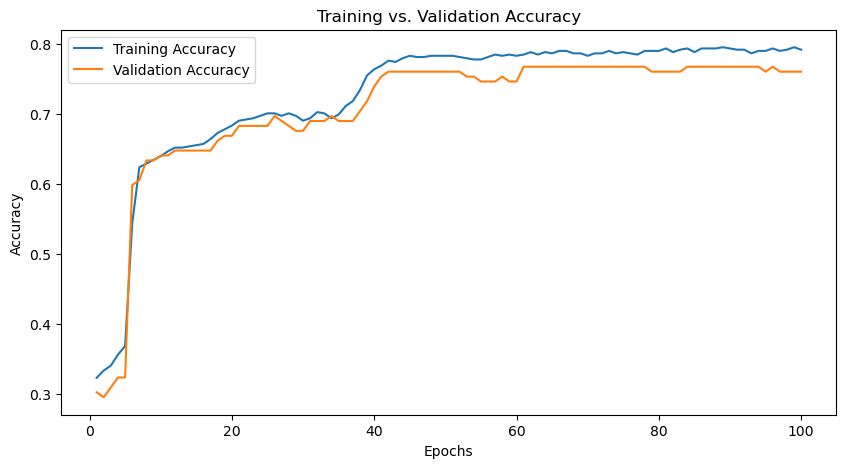

In [19]:
 # Plotting the results
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()

In [20]:

# Define two models: one regular and one that is likely to overfit
model_overfit = OverfitNet(D_in, H, D_out)  # Increase capacity for overfitting
model_overfit_drop = OverfitNetDrop(D_in, H, D_out, 0.5) # Drop layer including


In [21]:
print('Total number of parameters:', sum(p.numel() for p in model_overfit.parameters()))

Total number of parameters: 44328


In [22]:
# Train both models
#model_tr_regular, test_accuracies_regular, train_accuracies_regular = train_and_validation(model, train_loader, val_loader, num_epochs, learning_rate)
model_tr_overfit, test_accuracies_overfit, train_accuracies_overfit = train_and_validation(model_overfit, train_loader, val_loader, num_epochs, learning_rate)
model_tr_overfit_drop, test_accuracies_overfit_drop, train_accuracies_overfit_drop = train_and_validation(model_overfit_drop, train_loader, val_loader, num_epochs, learning_rate)


Validation set: Average loss: 0.6978, Accuracy: 58/142 (41%)
Epoch 1/100, Train Accuracy: 0.4056, Validation Accuracy: 0.4085
Validation set: Average loss: 0.6926, Accuracy: 93/142 (65%)
Epoch 2/100, Train Accuracy: 0.4056, Validation Accuracy: 0.6549
Validation set: Average loss: 0.6887, Accuracy: 84/142 (59%)
Epoch 3/100, Train Accuracy: 0.5979, Validation Accuracy: 0.5915
Validation set: Average loss: 0.6856, Accuracy: 84/142 (59%)
Epoch 4/100, Train Accuracy: 0.5944, Validation Accuracy: 0.5915
Validation set: Average loss: 0.6833, Accuracy: 84/142 (59%)
Epoch 5/100, Train Accuracy: 0.5944, Validation Accuracy: 0.5915
Validation set: Average loss: 0.6814, Accuracy: 84/142 (59%)
Epoch 6/100, Train Accuracy: 0.5944, Validation Accuracy: 0.5915
Validation set: Average loss: 0.6799, Accuracy: 84/142 (59%)
Epoch 7/100, Train Accuracy: 0.5944, Validation Accuracy: 0.5915
Validation set: Average loss: 0.6787, Accuracy: 84/142 (59%)
Epoch 8/100, Train Accuracy: 0.5944, Validation Accuracy:

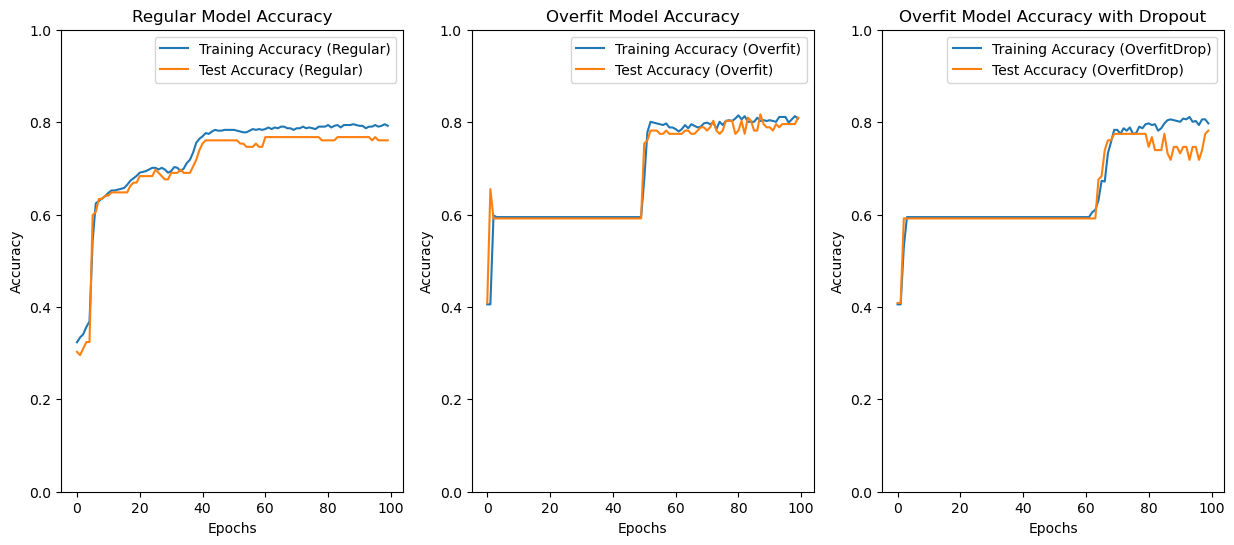

In [23]:
# Comparaison of both model
plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
plt.plot(train_accuracies, label='Training Accuracy (Regular)')
plt.plot(val_accuracies, label='Test Accuracy (Regular)')
plt.title('Regular Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Set the y-axis to start at 0
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies_overfit, label='Training Accuracy (Overfit)')
plt.plot(test_accuracies_overfit, label='Test Accuracy (Overfit)')
plt.title('Overfit Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_accuracies_overfit_drop, label='Training Accuracy (OverfitDrop)')
plt.plot(test_accuracies_overfit_drop, label='Test Accuracy (OverfitDrop)')
plt.title('Overfit Model Accuracy with Dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()

N=3, H=1, Activation=relu, Training Accuracy=0.4056, Test Accuracy=0.4085
N=3, H=3, Activation=relu, Training Accuracy=0.5944, Test Accuracy=0.5915
N=3, H=10, Activation=relu, Training Accuracy=0.6136, Test Accuracy=0.5986
N=3, H=30, Activation=relu, Training Accuracy=0.7885, Test Accuracy=0.7746
N=3, H=100, Activation=relu, Training Accuracy=0.7762, Test Accuracy=0.7676
N=30, H=1, Activation=relu, Training Accuracy=0.5944, Test Accuracy=0.5915
N=30, H=3, Activation=relu, Training Accuracy=0.5944, Test Accuracy=0.5915
N=30, H=10, Activation=relu, Training Accuracy=0.5944, Test Accuracy=0.5915
N=30, H=30, Activation=relu, Training Accuracy=0.5944, Test Accuracy=0.5915
N=30, H=100, Activation=relu, Training Accuracy=0.5944, Test Accuracy=0.5915
N=300, H=1, Activation=relu, Training Accuracy=0.5944, Test Accuracy=0.5915
N=300, H=3, Activation=relu, Training Accuracy=0.4056, Test Accuracy=0.4085
N=300, H=10, Activation=relu, Training Accuracy=0.5944, Test Accuracy=0.5915
N=300, H=30, Activ

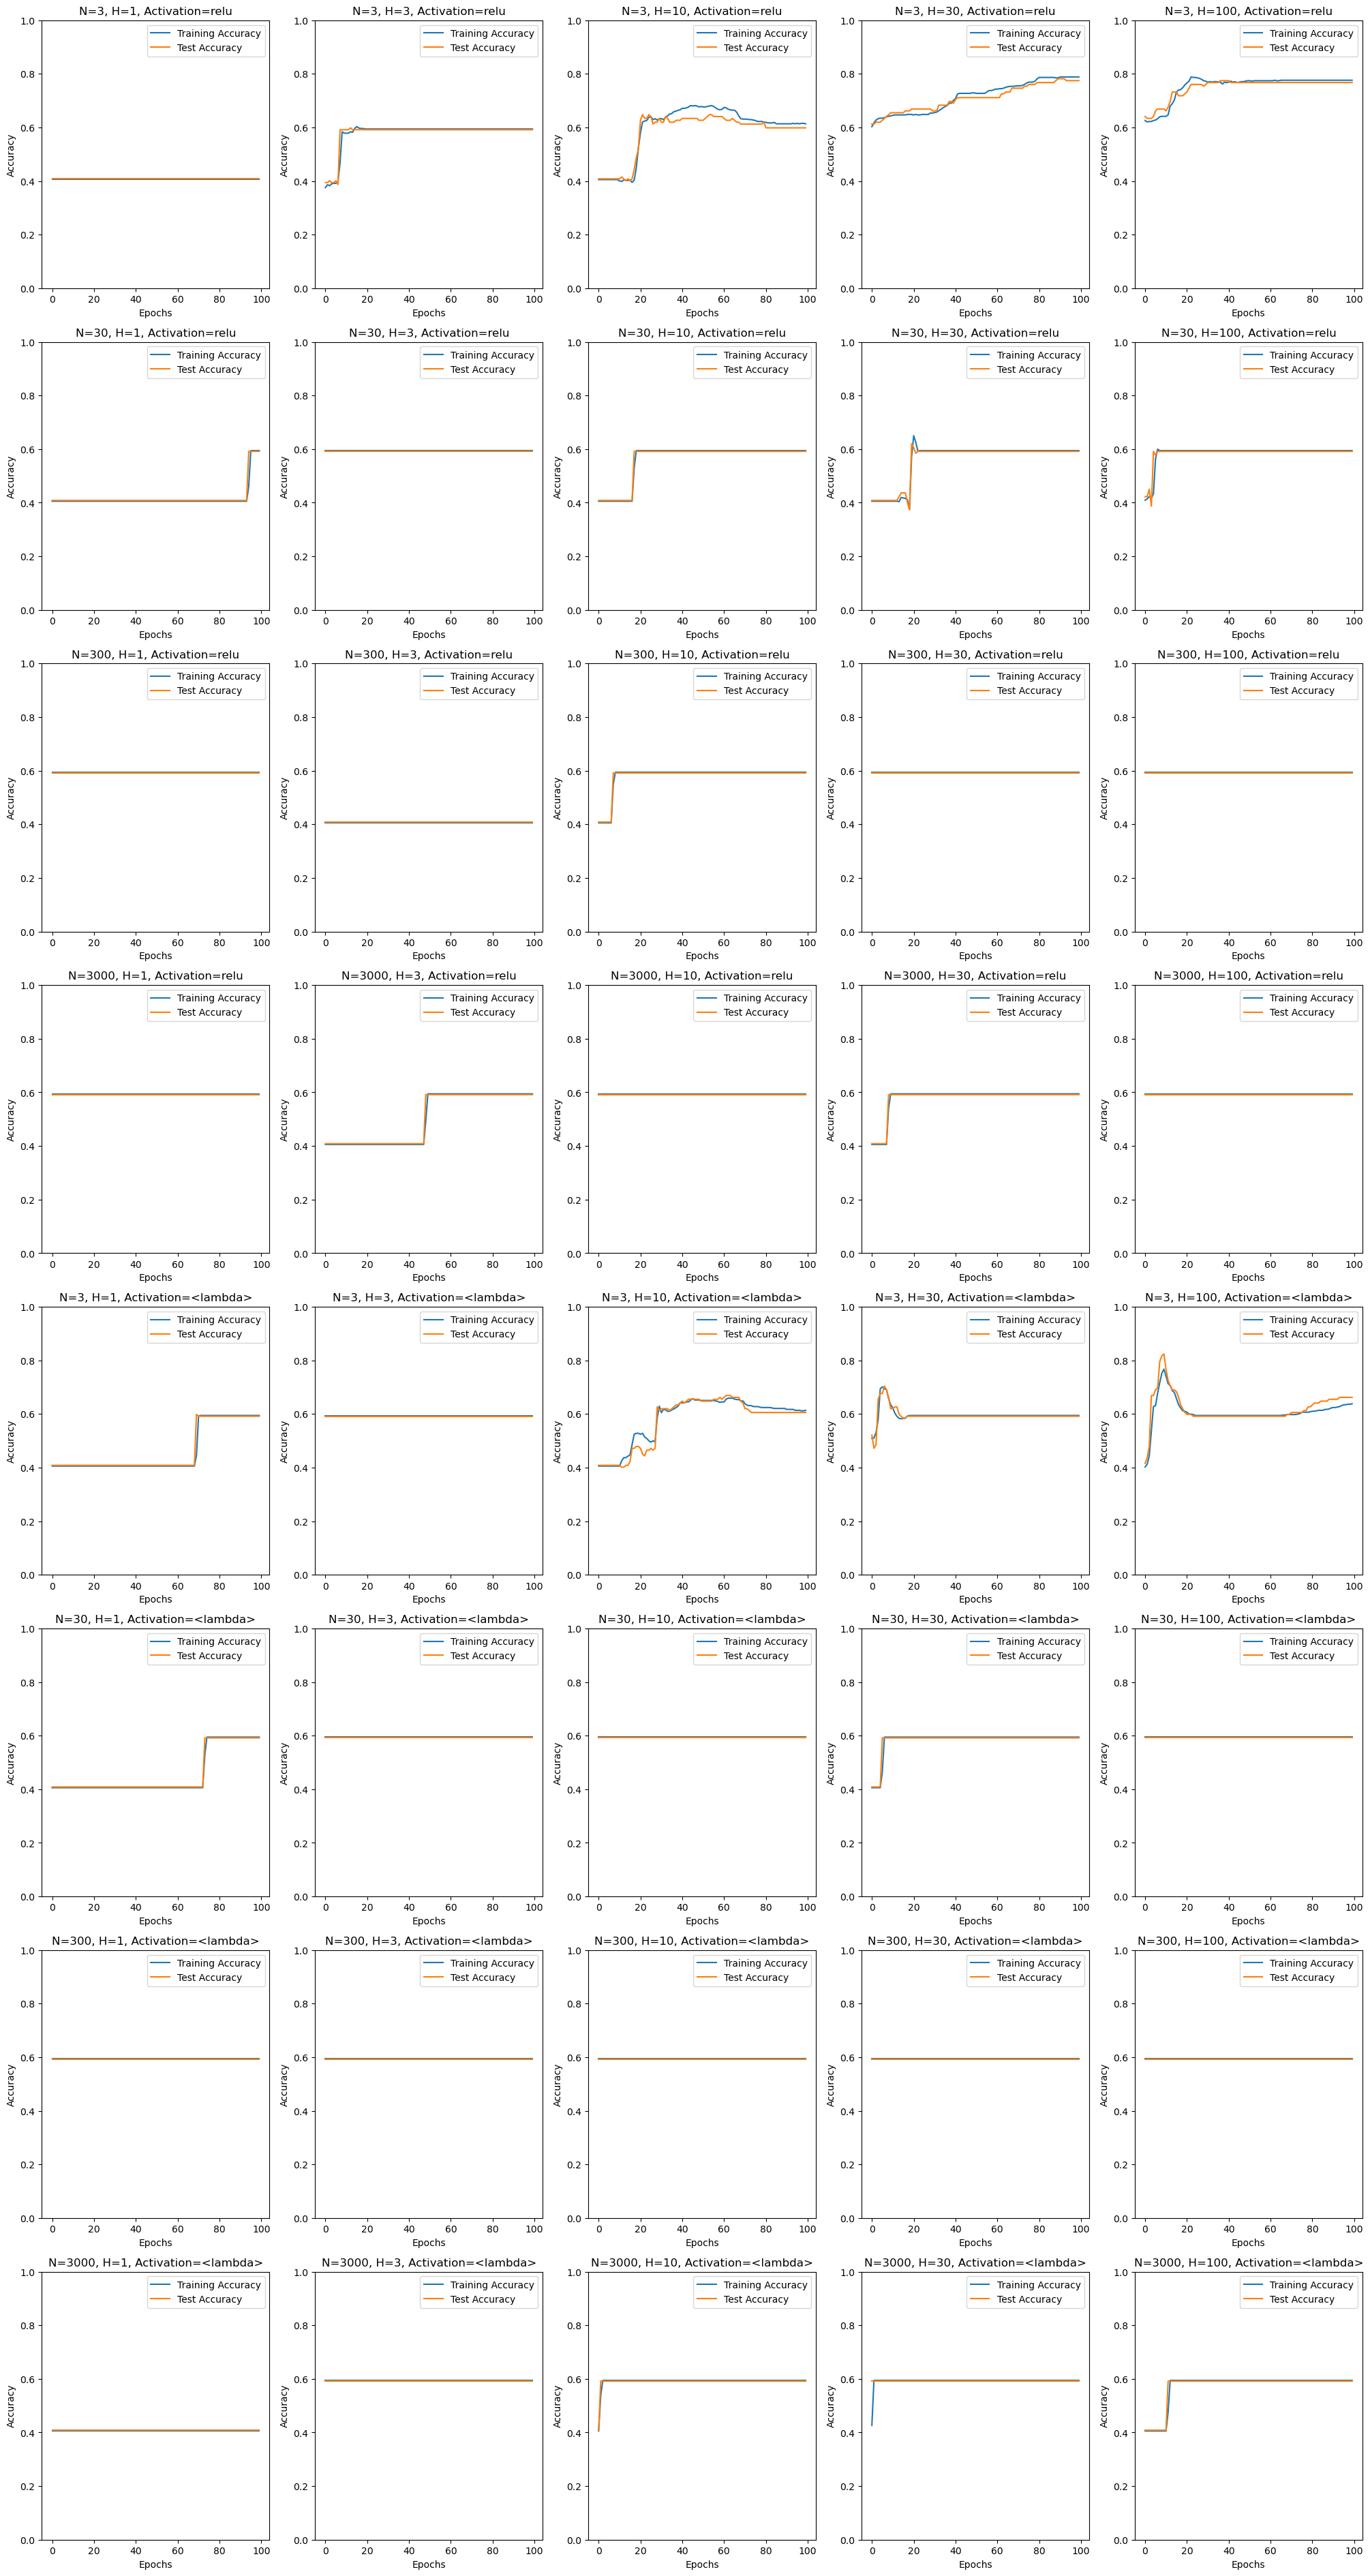

In [26]:
N = [3, 30, 300, 3000]
H = [1, 3, 10, 30, 100]

act_func = [F.relu, lambda x: x]

# Comparaison of models
plt.figure(figsize=(5*len(H),6*len(N)*len(act_func)))

learning_rate = 0.001

for i1 in range(len(act_func)):
    for i2 in range(len(N)):
        for i3 in range(len(H)):
            model = NLayerNet(D_in, [H[i3]]*N[i2], D_out, act_func[i1])
            model_tr, test_accuracies, train_accuracies = train_and_validation(model, train_loader, val_loader, num_epochs, learning_rate, silent=True)
            plt.subplot(len(N)*len(act_func), len(H), i1*len(N)*len(H) + i2*len(H) + i3 + 1)
            plt.plot(train_accuracies, label='Training Accuracy')
            plt.plot(test_accuracies, label='Test Accuracy')
            plt.title(f'N={N[i2]}, H={H[i3]}, Activation={act_func[i1].__name__}')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.ylim([0, 1])  # Set the y-axis to start at 0
            plt.legend()
            print(f'N={N[i2]}, H={H[i3]}, Activation={act_func[i1].__name__}, Training Accuracy={train_accuracies[-1]:.4f}, Test Accuracy={test_accuracies[-1]:.4f}')

